In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-6225ef42-f364-53a6-fa71-39c393539c30)


In [3]:
import tensorflow as tf
print(tf.__version__)


2.8.0


In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.python.keras import layers, models
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [5]:
from google.colab import drive
drive.mount('/ShardDrives/',force_remount=True)

Mounted at /ShardDrives/


In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/ShardDrives/MyDrive/ds/train'
valid_path = '/ShardDrives/MyDrive/ds/test'

In [7]:
img_height, img_width = 224,224

In [8]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [9]:


for layer in vgg19.layers:
    layer.trainable=False

In [10]:
# useful for getting number of output classes
folders = glob('/ShardDrives/MyDrive/ds/train/*')

In [11]:
folders

['/ShardDrives/MyDrive/ds/train/n',
 '/ShardDrives/MyDrive/ds/train/v',
 '/ShardDrives/MyDrive/ds/train/b']

In [12]:
# our layers - you can add more if you want
x = Flatten()(vgg19.output)

In [13]:
len(folders)

3

In [14]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
from tensorflow.keras.optimizers import Adam
adam_fine = Adam(learning_rate=0.00002)

In [17]:
# tell the model what cost and optimization method to use
model.compile(
  loss = 'categorical_crossentropy',
  optimizer= adam_fine,
  metrics=['accuracy']
)

In [18]:
batch_size = 32

In [19]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [20]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/ShardDrives/MyDrive/ds/train',
                                                 target_size = (img_height, img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',shuffle=False)

Found 7068 images belonging to 3 classes.


In [21]:
test_set = test_datagen.flow_from_directory('/ShardDrives/MyDrive/ds/test',
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',shuffle=False)

Found 771 images belonging to 3 classes.


In [22]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs =100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
221/221 [==============================] - 2893s 13s/step - loss: 5.0714 - accuracy: 0.4949 - val_loss: 3.1959 - val_accuracy: 0.6044
Epoch 2/100
221/221 [==============================] - 105s 475ms/step - loss: 2.8609 - accuracy: 0.6399 - val_loss: 2.8839 - val_accuracy: 0.6615
Epoch 3/100
221/221 [==============================] - 103s 466ms/step - loss: 2.2535 - accuracy: 0.7063 - val_loss: 2.7759 - val_accuracy: 0.6680
Epoch 4/100
221/221 [==============================] - 98s 442ms/step - loss: 2.0778 - accuracy: 0.7313 - val_loss: 2.5422 - val_accuracy: 0.7043
Epoch 5/100
221/221 [==============================] - 97s 437ms/step - loss: 1.7848 - accuracy: 0.7559 - val_loss: 2.1307 - val_accuracy: 0.7160
Epoch 6/100
221/221 [==============================] - 102s 463ms/step - loss: 1.6613 - accuracy: 0.7716 - val_loss: 2.2987 - val_accuracy: 0.7082
Epoch 7/100
221/221 [==============================] - 106s 477ms/step - loss: 1.6704 - accuracy: 0.7654 - val_loss: 1.98

In [23]:
import matplotlib.pyplot as plt

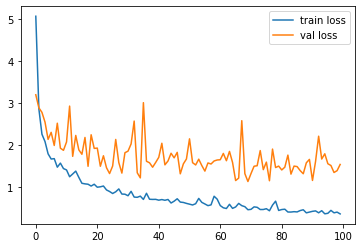

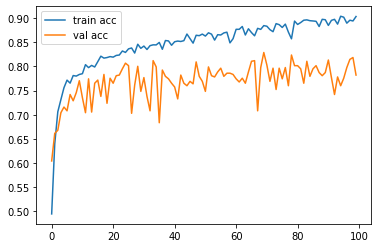

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:

# save it as a h5 file


from tensorflow.keras.models import load_model

FLOW1_model=model.save('vgg_50.h5')

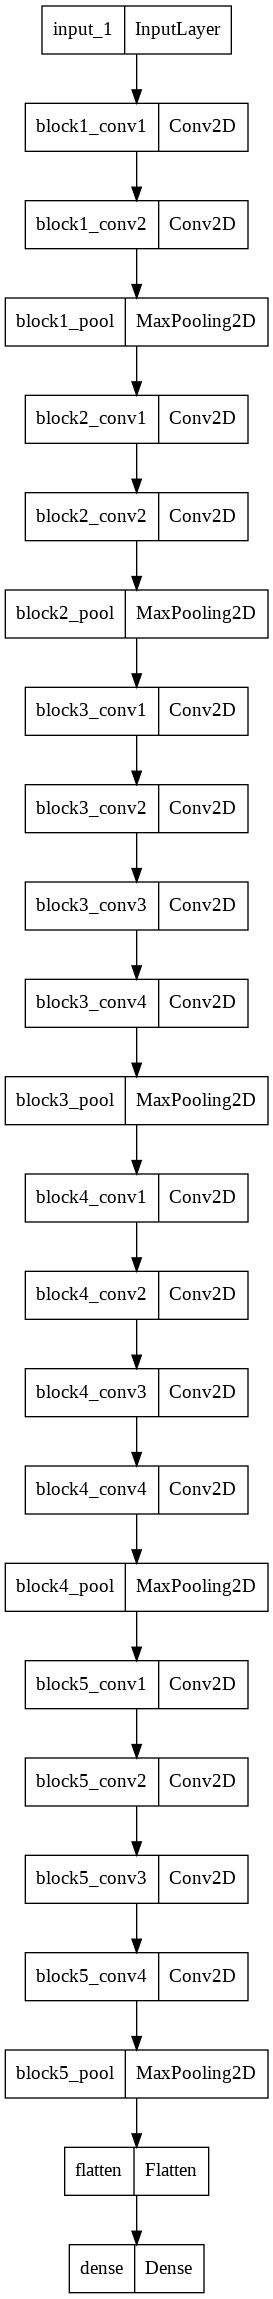

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [27]:
model1 = load_model('vgg_50.h5')

In [28]:
Y_pred = model1.predict_generator(test_set)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [29]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion matrix : \n',cm)

Confusion matrix : 
 [[236   3   3]
 [ 38 232  35]
 [ 74   3 147]]


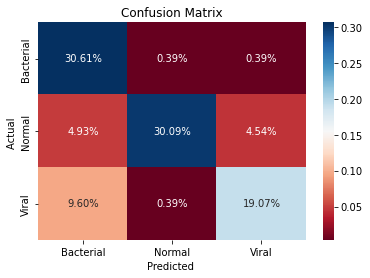

In [30]:
import seaborn as sns
ax=sns.heatmap(cm/np.sum(cm),annot=True,cmap='RdBu',fmt='.2%')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted ')
ax.set_ylabel('Actual ')
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
ax.yaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
plt.show()

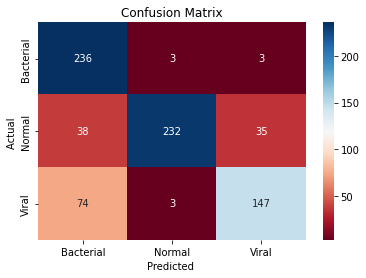

In [31]:
import seaborn as sns
ax=sns.heatmap(cm,annot=True,cmap='RdBu',fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted ')
ax.set_ylabel('Actual ')
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
ax.yaxis.set_ticklabels(['Bacterial','Normal', 'Viral'])
plt.show()

In [32]:
# classification report for precision, recall f1-score and accuracy
cm= classification_report(test_set.classes, y_pred)
print('Classification report : \n',cm)

Classification report : 
               precision    recall  f1-score   support

           0       0.68      0.98      0.80       242
           1       0.97      0.76      0.85       305
           2       0.79      0.66      0.72       224

    accuracy                           0.80       771
   macro avg       0.82      0.80      0.79       771
weighted avg       0.83      0.80      0.80       771



the output Image is  Normal


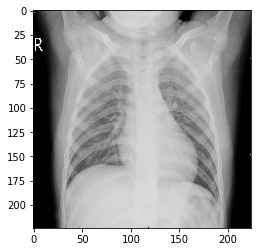

In [33]:
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
model = load_model('vgg_50.h5')
img = image.load_img('/ShardDrives/MyDrive/ds/val/image0.png', target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
output = model.predict(img_data)
plt.imshow(img)
output1 = { 0:'Bacteria',1:'Normal',2:'Viral'}
print("the output Image is ",output1[np.argmax(output)])

In [34]:
output

array([[0.0673044 , 0.9085335 , 0.02416208]], dtype=float32)

In [38]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(test_set.classes, y_pred)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy with Fine-Tuning: 79.77%


In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
